### Environment Setup

In [2]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [3]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from numpy.linalg import inv
from scipy import interpolate

from scipy.optimize import minimize
from sklearn.metrics import r2_score

%matplotlib inline

### Fake Data

0.0 5.0
500


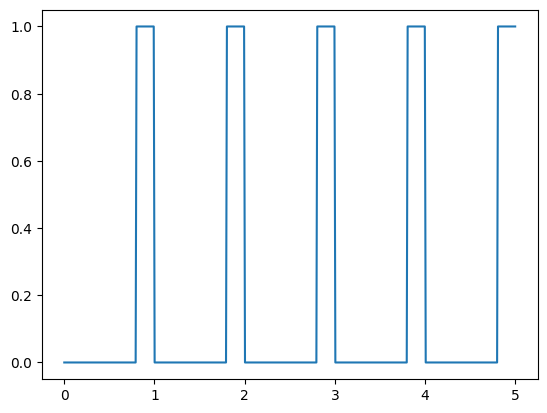

In [4]:
def make_flashes(time_start, time_end, pattern, n_repeats):
    flashes = np.tile(pattern, n_repeats)
    time_axis = np.linspace(time_start, time_end, len(flashes))
    return time_axis, flashes

time_axis, exog = make_flashes(0, 5, [0]*80 + [1]*20, 5)
print(time_axis[0], time_axis[-1])
print(len(exog))
plt.plot(time_axis, exog)

In [5]:
def make_spikes(stim, baseline_rate, coeff, return_exp=False):
    weighted_stim = (stim*coeff) + baseline_rate
    exp_stim = np.exp(weighted_stim)
    spikes = np.random.poisson(exp_stim)
    if return_exp:
        return spikes[1:], weighted_stim, exp_stim
    return spikes[1:]

spikes_binned, weighted_stim, exp_stim = make_spikes(exog, 0.05, 0.7, return_exp=True)
print(len(spikes_binned))

499


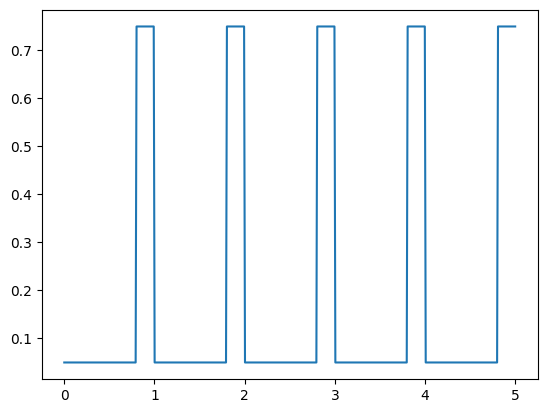

In [6]:
plt.plot(time_axis, weighted_stim)

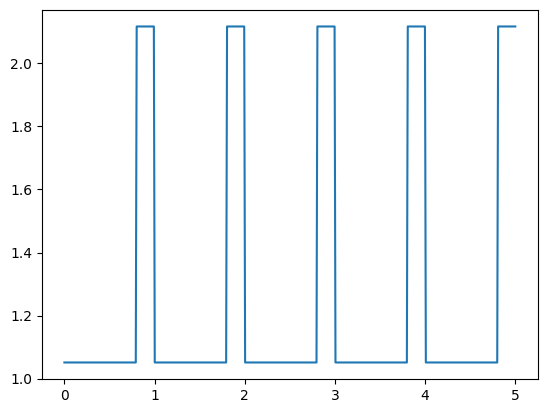

In [7]:
plt.plot(time_axis, exp_stim)

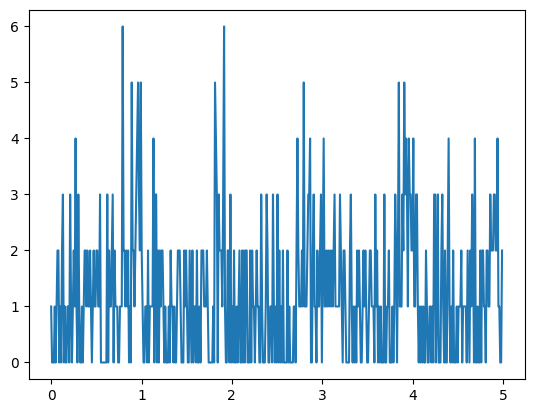

In [8]:
plt.plot(time_axis[:-1], spikes_binned)

### Design Matrix

In [9]:
# length of filter (# bins)
ntfilt = 1

In [10]:
def get_design_mat(ntfilt, stim, num_time_bins):
    padded_stim = np.hstack((np.zeros((ntfilt-1)), stim)) # pad early bins of stimulus with zero
    design_mat = np.zeros((num_time_bins,ntfilt))
    for j in np.arange(num_time_bins):
        design_mat[j] = padded_stim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat

In [11]:
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)

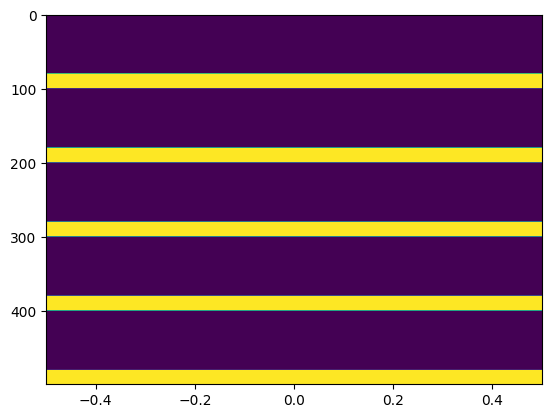

In [12]:
plt.imshow(design_mat, aspect="auto")

In [13]:
design_mat.shape

(499, 1)

### Class

In [14]:
def neglogli_poissGLM(thetas, xx, yy, dt_bin, vals_to_return=3):
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas # filter output
    # vv = xx @ thetas  # filter output
    rr = np.exp(vv) * dt_bin  # conditional intensity (per bin)

    if len(np.where(np.isnan(rr))[0]) > 0:
        print('at GLM filter output')

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy;  # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term
    neglogli = Trm1 + Trm0

    # ---------  Compute Gradient -----------------
    dL1 = -xx.T @ yy  # spiking term (the spike-triggered average)
    dL0 = xx.T @ rr  # non-spiking term
    dL = dL1 + dL0

    if len(np.where(np.isnan(dL0))[0]) > 0:
        print('At gradient')

    # ---------  Compute Hessian -------------------
    H = xx.T @ (xx * np.transpose([rr]))  # non-spiking term

    if len(np.where(np.isnan(H))[0]) > 0:
        print('At hessian')

    if vals_to_return == 3:
        return neglogli, dL, H
    else:
        return [neglogli, dL, H][vals_to_return]


In [15]:
def neglogposterior(thetas, neglogli_fun, Cinv, vals_to_return=3):
    neglogpost, grad, H = neglogli_fun(thetas)
    neglogpost = neglogpost + .5 * thetas.T @ Cinv @ thetas
    grad = grad + Cinv @ thetas
    H = H + Cinv

    if vals_to_return == 3:
        return neglogpost, grad, H
    else:
        return [neglogpost, grad, H][vals_to_return]

In [16]:
def fit(X, y, bin_sz=1, lam=8):
    # w0 = (X.T @ y) / np.sum(y)
    w0 = [0.05, 0.7]

    Imat = np.identity(X.shape[1])  # identity matrix of size of filter + const
    Imat[0, 0] = 0

    neglogli_func = lambda prs: neglogli_poissGLM(prs, X, y, bin_sz)

    Cinv = lam * Imat  # set inverse prior covariance
    loss_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=0)
    grad_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=1)
    hess_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=2)
    optimizer = minimize(fun=loss_post_func, x0=w0, method='trust-ncg', jac=grad_post_func,
                            hess=hess_post_func,
                            tol=1e-6, options={'disp': False, 'maxiter': 100})
    return optimizer.x

### Generating Filters

In [17]:
# filters = []
# for i, spike_times in enumerate(units_spike_times):
#     spike_times = units_spike_times[i]
#     these_spikes_binned, _ = np.histogram(spike_times, time_axis)
#     try:
#         res = fit(design_mat_offset, these_spikes_binned, 100, lam=2**10)
#         const, filt = res[0], res[1:]
#         filters.append(filt)
#         print(i)
#     except:
#         filters.append([])

In [18]:
# n_cols=10

# n_rows = ceil(len(filters)/n_cols)
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, n_rows))
# if len(axes.shape) == 1:
#     axes = axes.reshape((1, axes.shape[0]))

# for i in range(len(filters)):
#     f = filters[i]
#     row = i // n_cols
#     col = i % n_cols
#     axes[row][col].plot(f)
#     axes[row][col].set_ylabel(i)

# fig.tight_layout()
# plt.show()

In [19]:
# unit_idx = 134
# spike_times = units_spike_times[unit_idx]
# print(spike_times)

In [20]:
# num_spikes = len(time_axis)
# # spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
# spikes_binned,_ = np.histogram(spike_times, time_axis)

### Binning spikes

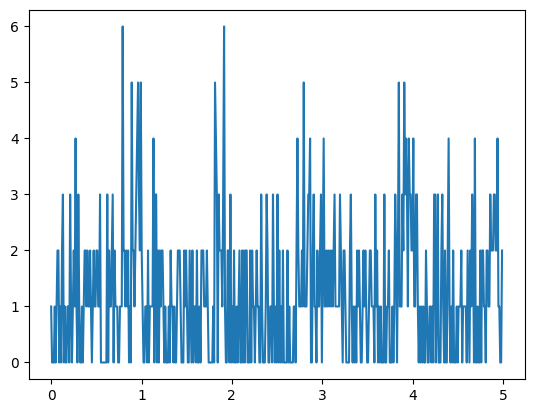

In [21]:
plt.plot(time_axis[:-1], spikes_binned)

### Fitting With Regularization

In [69]:
n_repeats = []
filters = []
constants = []
lambdas = []
bin_szs = []

repeat_trials = 13
lambda_trials = 10
bin_sz_trials = 10
for i in range(repeat_trials):
    # for j in range(lambda_trials):
    for j in range(bin_sz_trials):
        print("i:",i,"j:",j)
        repeats = 2**i
        time_axis, exog = make_flashes(0, repeats, [0]*80 + [1]*20, repeats)
        spikes_binned = make_spikes(exog, 0.1, 0.9)
        
        ntfilt = 1
        num_time_bins = len(exog)-1
        design_mat = get_design_mat(ntfilt, exog, num_time_bins)
        design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

        bin_sz = 1 ** (j-5)/2
        res = fit(design_mat_offset, spikes_binned, bin_sz=bin_sz, lam=0)
        constant, filter = res[0], res[1:]
        n_repeats.append(2**i)
        lambdas.append(0)
        filters.append(filter)
        constants.append(constant)
        bin_szs.append(bin_sz)

i: 0 j: 0
i: 0 j: 1
i: 0 j: 2
i: 0 j: 3
i: 0 j: 4
i: 0 j: 5
i: 0 j: 6
i: 0 j: 7
i: 0 j: 8
i: 0 j: 9
i: 1 j: 0
i: 1 j: 1
i: 1 j: 2
i: 1 j: 3
i: 1 j: 4
i: 1 j: 5
i: 1 j: 6
i: 1 j: 7
i: 1 j: 8
i: 1 j: 9
i: 2 j: 0
i: 2 j: 1
i: 2 j: 2
i: 2 j: 3
i: 2 j: 4
i: 2 j: 5
i: 2 j: 6
i: 2 j: 7
i: 2 j: 8
i: 2 j: 9
i: 3 j: 0
i: 3 j: 1
i: 3 j: 2
i: 3 j: 3
i: 3 j: 4
i: 3 j: 5
i: 3 j: 6
i: 3 j: 7
i: 3 j: 8
i: 3 j: 9
i: 4 j: 0
i: 4 j: 1
i: 4 j: 2
i: 4 j: 3
i: 4 j: 4
i: 4 j: 5
i: 4 j: 6
i: 4 j: 7
i: 4 j: 8
i: 4 j: 9
i: 5 j: 0
i: 5 j: 1
i: 5 j: 2
i: 5 j: 3
i: 5 j: 4
i: 5 j: 5
i: 5 j: 6
i: 5 j: 7
i: 5 j: 8
i: 5 j: 9
i: 6 j: 0
i: 6 j: 1
i: 6 j: 2
i: 6 j: 3
i: 6 j: 4
i: 6 j: 5
i: 6 j: 6
i: 6 j: 7
i: 6 j: 8
i: 6 j: 9
i: 7 j: 0
i: 7 j: 1
i: 7 j: 2
i: 7 j: 3
i: 7 j: 4
i: 7 j: 5
i: 7 j: 6
i: 7 j: 7
i: 7 j: 8
i: 7 j: 9
i: 8 j: 0
i: 8 j: 1
i: 8 j: 2
i: 8 j: 3
i: 8 j: 4
i: 8 j: 5
i: 8 j: 6
i: 8 j: 7
i: 8 j: 8
i: 8 j: 9
i: 9 j: 0
i: 9 j: 1
i: 9 j: 2
i: 9 j: 3
i: 9 j: 4
i: 9 j: 5
i: 9 j: 6
i: 9 j: 7
i: 9 j: 8
i: 9 j: 9


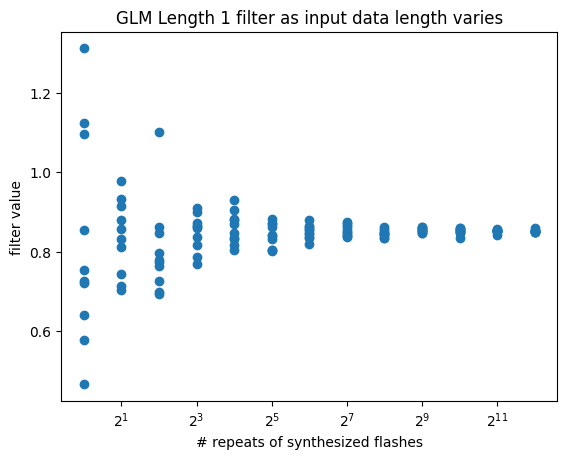

In [70]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Length 1 filter as input data length varies")
ax.set_xlabel("# repeats of synthesized flashes")
ax.set_ylabel("filter value")
ax.scatter(n_repeats, filters)

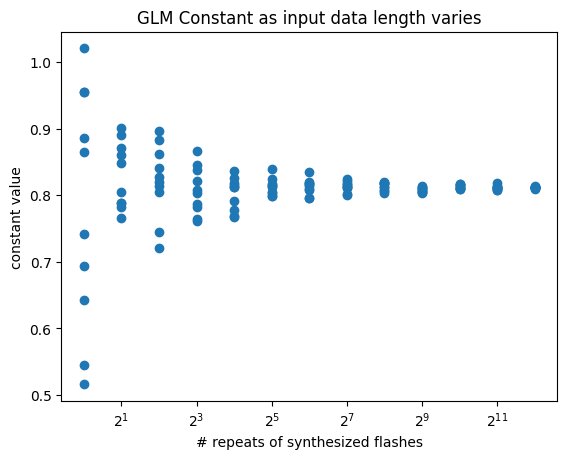

In [71]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Constant as input data length varies")
ax.set_xlabel("# repeats of synthesized flashes")
ax.set_ylabel("constant value")
ax.scatter(n_repeats, constants)

C:\Users\carter.peene\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


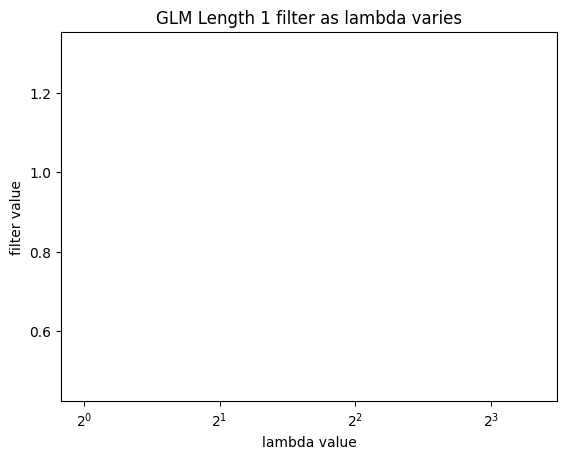

In [72]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Length 1 filter as lambda varies")
ax.set_xlabel("lambda value")
ax.set_ylabel("filter value")
ax.scatter(lambdas, filters)

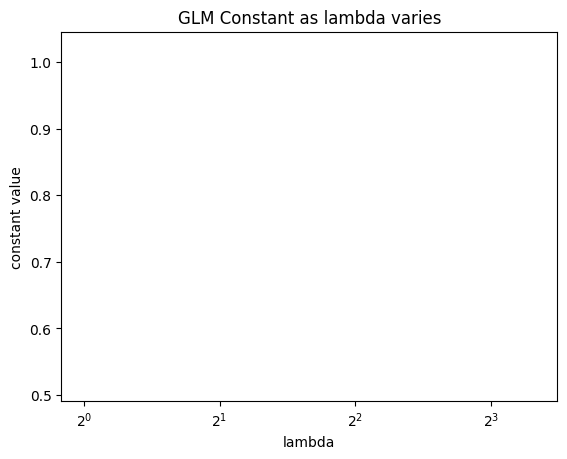

In [73]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Constant as lambda varies")
ax.set_xlabel("lambda")
ax.set_ylabel("constant value")
ax.scatter(lambdas, constants)

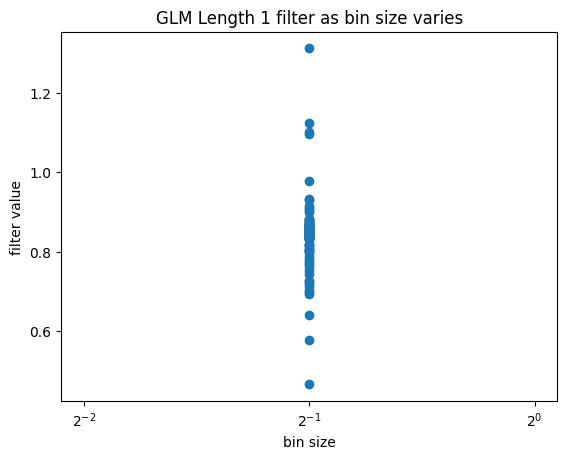

In [74]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Length 1 filter as bin size varies")
ax.set_xlabel("bin size")
ax.set_ylabel("filter value")
ax.scatter(bin_szs, filters)

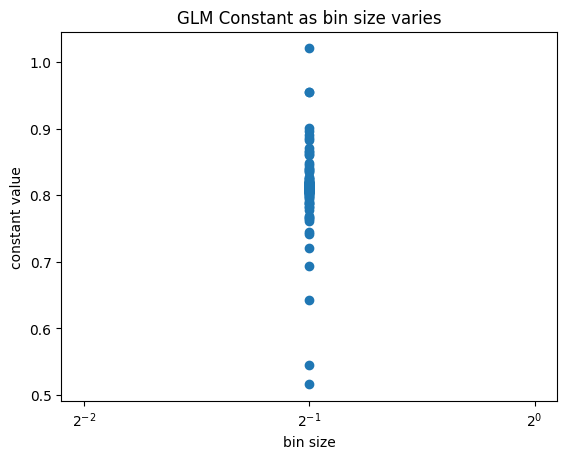

In [75]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Constant as bin size varies")
ax.set_xlabel("bin size")
ax.set_ylabel("constant value")
ax.scatter(bin_szs, constants)

In [76]:
print(np.mean(constants), np.mean(filters))

0.8108029225779735 0.8441949332065181


### Predict Activity

In [55]:
time_axis, exog = make_flashes(0, 5000, [0]*80 + [1]*20, repeats)
spikes_binned = make_spikes(exog, 0.05, 0.7)

ntfilt = 1
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)
design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

res = fit(design_mat_offset, spikes_binned, bin_sz=0.01, lam=0)
constant, filter = res[0], res[1:]
print(constant, filter)

4.668069897924478 [0.65984099]


In [56]:
def predict(X, weights, constant, bin_sz=1):
    y = np.exp(X @ weights + constant) * bin_sz
    return y

def predict_spikes(X, weights, constant, bin_sz=1):
    rate = predict(X, weights, constant, bin_sz)
    spks = np.random.poisson(np.matrix.transpose(rate))
    return spks

In [57]:
### predict
predictions = []
for j in range(100):
    predictions.append(predict_spikes(design_mat, filter, constant))

-12033.200219843142
1.2639483983115194
126.38086274624693


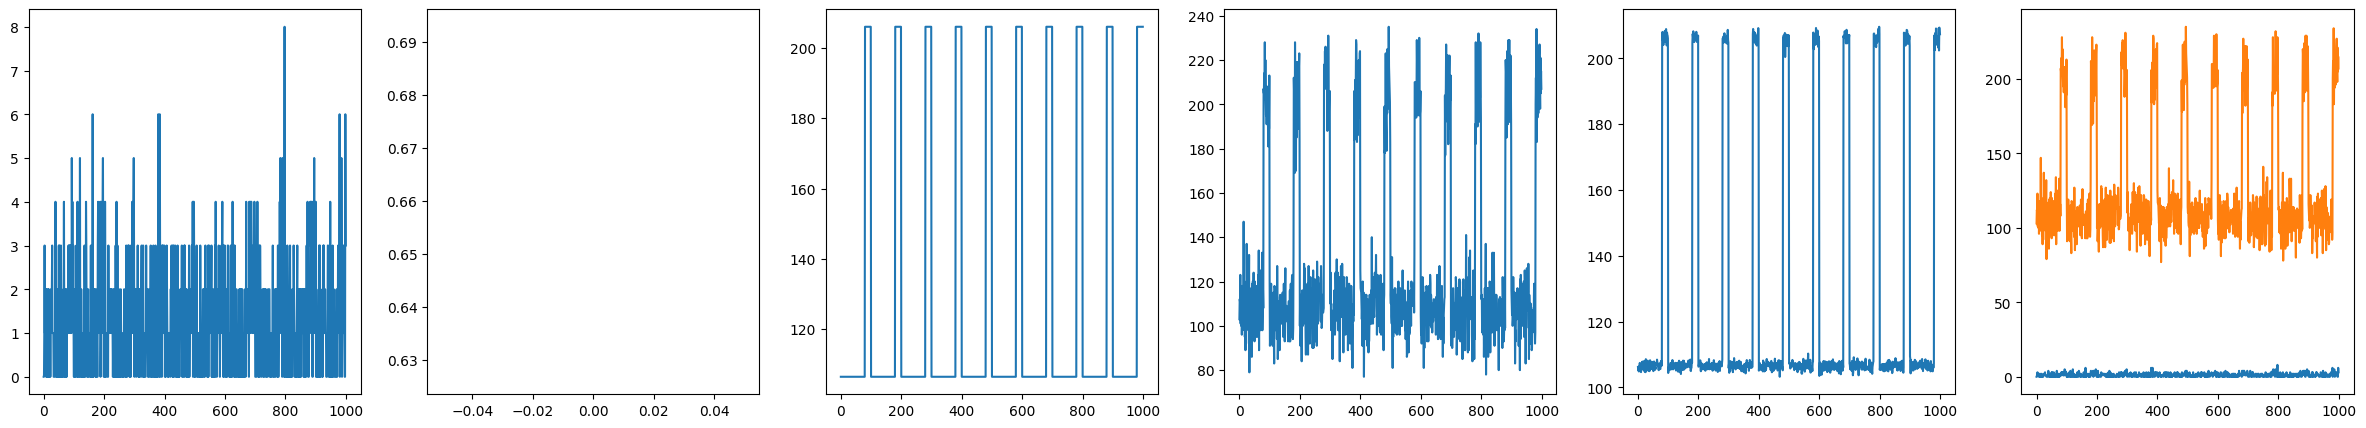

In [58]:
fig, axes = plt.subplots(1,6, figsize=(30,5))

prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
avg_predicted = np.mean(predictions, axis=0)

axes[0].plot(spikes_binned[0:1000])
axes[1].plot(filter)
axes[2].plot(prob_predicted[0:1000])
axes[3].plot(spikes_predicted[0:1000])
axes[4].plot(avg_predicted[0:1000])
axes[5].plot(spikes_binned[0:1000])
axes[5].plot(spikes_predicted[0:1000])

print(r2_score(spikes_binned, spikes_predicted))
print(np.sum(spikes_binned) / len(spikes_binned))
print(np.sum(spikes_predicted) / len(spikes_predicted))

plt.show()

In [59]:
mse2 = np.mean((spikes_binned-spikes_predicted)**2)  # mean squared error, with offset
rss = np.mean((spikes_binned-np.mean(spikes_binned))**2)    # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, w/ offset: {:.2f}'.format(1-mse2/rss))

Training perf (R^2): lin-gauss GLM, w/ offset: -12033.20


In [60]:
# # %matplotlib

# fig, axes = plt.subplots(20,6, figsize=(30,30))
# for i in range(20):
#     t = 120
#     unit_idx = 120+i
#     spike_times = units_spike_times[unit_idx]

#     num_spikes = len(time_axis)
#     # spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
#     spikes_binned,_ = np.histogram(spike_times, time_axis)

#     ### fit
#     design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones
#     res = fit(design_mat_offset, spikes_binned, lam=2**10)
#     constant, filter = res[0], res[1:]

#     ### predict
#     predictions = []
#     for j in range(1000):
#         predictions.append(predict_spikes(design_mat, filter, constant))

#     prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
#     spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
#     avg_predicted = np.mean(predictions, axis=0)

#     axes[i][0].plot(spikes_binned[20000:30000])
#     axes[i][1].plot(filter)
#     axes[i][2].plot(prob_predicted[20000:30000])
#     axes[i][3].plot(spikes_predicted[20000:30000])
#     axes[i][4].plot(avg_predicted[20000:30000], lw=0.05)
#     axes[i][5].plot(spikes_binned[20000:30000])
#     axes[i][5].plot(spikes_predicted[20000:30000])

#     print(i, r2_score(spikes_binned, spikes_predicted))

# plt.show()